# Script to connect with copernicus API and download all available images as .tif files for aspecific AOI and time range

In [70]:
# Utilities
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import getpass
import numpy as np
from typing import Any, Optional, Tuple
from datetime import datetime, timedelta
import os
import shutil
from pathlib import Path
import xarray as xr
import rioxarray as rxr 
import re
from sentinelhub import (SHConfig, DataCollection, SentinelHubCatalog, SentinelHubRequest, SentinelHubStatistical, BBox,
    bbox_to_dimensions, CRS, MimeType, Geometry, SentinelHubDownloadClient)

In [84]:
# Functions
# reorganize folder structure of results
def process_tiff_files(base_path):

    # Define the base path
    base_path = Path("ndsi_data/Achensee_2023-24")
    target_path = base_path # where we want the results after reorganizing

    # List all date folders
    date_folders = [folder for folder in base_path.iterdir() if folder.is_dir()]

    # Iterate over each date folder
    for date_folder in date_folders:
        # Get the path of the nested folder inside the date folder
        nested_folders = [folder for folder in date_folder.iterdir() if folder.is_dir()]
        
        # Check if there is exactly one nested folder
        if len(nested_folders) == 1:
            nested_folder = nested_folders[0]
            
            # Find the response.tif file inside the folder
            tif_files = [file for file in nested_folder.iterdir() if file.is_file() and file.name == "response.tiff"]
            
            # Check if there is exactly one response.tif file
            if len(tif_files) == 1:
                tif_file = tif_files[0]
                
                # Define the new file name and path
                new_file_name = f"ndsi_{date_folder.name}.tiff"
                new_file_path = target_path / new_file_name
                
                # Move and rename the file
                shutil.move(tif_file, new_file_path)
                print(f"Moved and renamed {new_file_path}")
                
                # Delete the date folder
                shutil.rmtree(date_folder)

    print("results have been reorganized. :)")


## set up connection to API

In [72]:
# Configuration
# Set up your Sentinel Hub configuration if already done and saved, else activate next code box
config = SHConfig("MO")

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")
else: print("Connection successful")

Connection successful


In [73]:
# # Set up your Sentinel Hub configuration if not already done
# config = SHConfig()

# # Sentinel account info
# config.instance_id = "607e0864-6586-4c05-a03e-6b32dbdf464d"  # Replace with your Sentinel Hub instance ID                                           fc2993a7-a8a9-4df5-8654-a32bd1472bda
# config.sh_client_id = "sh-12fdab4a-a8cc-422f-b2af-552cb6181f69"  # Replace with your client ID
# config.sh_client_secret = "AWaIlsPCPltpCc0iRImBPmS1NABSjJhh"  # Replace with your client secret
# config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
# config.sh_base_url = "https://sh.dataspace.copernicus.eu"

# config.save()

# # test connection
# config = SHConfig()

# if not config.sh_client_id or not config.sh_client_secret:
#     print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")
# else: print("Connection successful")

## define the variables!

### coordinates examples
test 1: 11.669884, 47.429597, 11.834679, 47.484555                 (wgs84 - 4326) Achensee region small area 

test 2: 697989.4242, 5259657.0058, 707033.7375, 5268705.5889       (utm 32N - 32632) Achensee region small area

Achensee full extent: 688675, 5250625, 710875, 5274625

define your own bbox coordinates here: http://bboxfinder.com

In [74]:
# define variables
Achensee_coords = (688675, 5250625, 710875, 5274625)    # Coordinates of the box in  wgs84 (http://bboxfinder.com)
epsg = 32632                                                                # define the epsg code of the coordinates
resolution = 20                                                             # resolution in meters
time_interval = "2023-10-01", "2024-08-31"                                  # time interval: for this time interval all available images are being downloaded
output_folder = "ndsi_data/Achensee_2023-24"                                        # define the location of the output folder
cloud_mask = 50                                                           # % of the max. cloud cover for the images that should be included in the search (clouds are masked and set to na later)

In [75]:
Achensee_bbox = BBox(bbox=Achensee_coords, crs=CRS(epsg))   # define bbox
Achensee_size = bbox_to_dimensions(Achensee_bbox, resolution=resolution)   # define size
aoi_bbox = Achensee_bbox

print(f"Image shape at {resolution} m resolution: {Achensee_size} pixels")

Image shape at 20 m resolution: (1110, 1200) pixels


In [76]:
# search in catalog for all available images with the defined varables
catalog = SentinelHubCatalog(config=config)

search_iterator = catalog.search(       
    DataCollection.SENTINEL2_L2A,
    bbox=aoi_bbox,
    time=time_interval,
    fields={"include": ["id", "properties.datetime"], "exclude": []},
    filter=f"eo:cloud_cover < {cloud_mask}"
)

results = list(search_iterator)
# print("Total number of results:", len(results))

# Create a list of unique days in time_interval
date_list = list({result["properties"]["datetime"][:10] for result in results})
date_list.sort()  # Optional: Sort dates chronologically
# Convert to a list of datetime objects
datetime_list = [datetime.strptime(date, '%Y-%m-%d') for date in date_list]
print("Total number of available days = ", len(datetime_list))
datetime_list

Total number of available days =  51


[datetime.datetime(2023, 10, 3, 0, 0),
 datetime.datetime(2023, 10, 10, 0, 0),
 datetime.datetime(2023, 10, 13, 0, 0),
 datetime.datetime(2023, 10, 23, 0, 0),
 datetime.datetime(2023, 10, 25, 0, 0),
 datetime.datetime(2023, 10, 28, 0, 0),
 datetime.datetime(2023, 11, 4, 0, 0),
 datetime.datetime(2023, 11, 27, 0, 0),
 datetime.datetime(2023, 11, 29, 0, 0),
 datetime.datetime(2023, 12, 7, 0, 0),
 datetime.datetime(2023, 12, 9, 0, 0),
 datetime.datetime(2023, 12, 17, 0, 0),
 datetime.datetime(2023, 12, 19, 0, 0),
 datetime.datetime(2023, 12, 27, 0, 0),
 datetime.datetime(2024, 1, 1, 0, 0),
 datetime.datetime(2024, 1, 3, 0, 0),
 datetime.datetime(2024, 1, 11, 0, 0),
 datetime.datetime(2024, 1, 13, 0, 0),
 datetime.datetime(2024, 1, 16, 0, 0),
 datetime.datetime(2024, 1, 28, 0, 0),
 datetime.datetime(2024, 2, 5, 0, 0),
 datetime.datetime(2024, 2, 7, 0, 0),
 datetime.datetime(2024, 2, 15, 0, 0),
 datetime.datetime(2024, 2, 25, 0, 0),
 datetime.datetime(2024, 3, 8, 0, 0),
 datetime.datetime(2

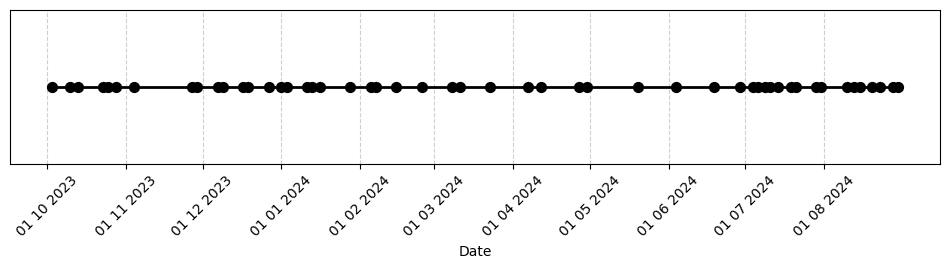

In [77]:
# Create figure
fig, ax = plt.subplots(figsize=(12, 2))

# Plot the horizontal timeline
ax.hlines(y=1, xmin=min(datetime_list), xmax=max(datetime_list), color="black", linewidth=2)

# Plot event points
ax.scatter(datetime_list, [1] * len(datetime_list), color="black", s=50, label="Events", zorder=3)

# Remove y-axis
ax.yaxis.set_visible(False)

# Set month ticks at the 15th of each month
months = sorted(set((dt.year, dt.month) for dt in datetime_list))  # Unique (year, month) pairs
month_ticks = [datetime(year, month, 1) for year, month in months]  # Middle of the month

# Format the x-axis
ax.set_xticks(month_ticks)
ax.set_xticklabels([dt.strftime("%d %m %Y") for dt in month_ticks], rotation=45)

# Formatting
ax.set_xlabel("Date")
ax.grid(axis="x", linestyle="--", alpha=0.6)

plt.show()


In [78]:
# evalscript_ndsi = """
# //VERSION=3
# function setup() {
#   return {
#     input: ["B03", "B11"],  // Add CLD band to input
#     output: { bands: 1, sampleType: "FLOAT32" }
#   };
# }

# function evaluatePixel(sample) {
#   // Calculate NDSI
#   let ndsi = (sample.B03 - sample.B11) / (sample.B03 + sample.B11);
#   return [ndsi];
# }
# """

In [79]:
# mask the images by scl layer. Select the classes to mask in the list.
eval_ndsi_scl_mask = """
//VERSION=3
function setup() {
  return {
    input: ["B03", "B11", "SCL"], // select bands
    output: { bands: 1, sampleType: "FLOAT32" }
  };
}

function evaluatePixel(sample) {
  let ndsi = (sample.B03 - sample.B11) / (sample.B03 + sample.B11); // calculate ndsi
  let image_mask = sample.SCL; // create mask out of SCL layer

  // !Adjust the mask here!
  // 0=nodata; 1=saturated or defective; 2=dark features/shadows; 3=cloud sahdows; 4=vegetation; 5=not vegetated; 
  // 6=water; 7=unclassified; 8=cloud medium probab; 9=cloud high probab; 10=thin cirrus; 10=snow/ice
  let mask_values = [1,6,8,9]; // define mask values from SCL classes

  // Set NDSI to NaN where mask is defined
  let ndsi_masked = mask_values.includes(image_mask) ? NaN : ndsi;

  return [ndsi_masked];
} 
"""

In [80]:
# eval_ndsi_cloud2 = """
# //VERSION=3
# function setup() {
#   return {
#     input: ["B03", "B11", "CLD"],  // Add CLD band to input
#     output: { bands: 1, sampleType: "FLOAT32" }
#   };
# }

# function evaluatePixel(sample) {
#   // Calculate NDSI
#   let ndsi = (sample.B03 - sample.B11) / (sample.B03 + sample.B11);
  
#   // Apply cloud mask: Set cloudy pixels to NaN
#   let ndsi_masked = sample.CLD > 0.5 ? NaN : ndsi;  // Cloud mask threshold can be adjusted
  
#   return [ndsi_masked];
# }

# """

In [81]:
ndsi_images = []
# loop over all available dates found in the catalog for the time series
for current_date in datetime_list:
    # Define the time interval as a string
    time_interval = (current_date.strftime("%Y-%m-%d"), (current_date + timedelta(days=0)).strftime("%Y-%m-%d"))
    print(f"downloading tif for {time_interval[0]}")
    # define request with the time interval
    request_ndsi = SentinelHubRequest(
        data_folder=(f"{output_folder}/{time_interval[0]}"),
        
        evalscript=eval_ndsi_scl_mask,   # select eval script
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A.define_from(   # select data collection
                    "s2l2a", service_url=config.sh_base_url
                ),
                time_interval=time_interval,   # define processed time interval
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],   # select output format (TIFF)
        bbox=Achensee_bbox,
        size=Achensee_size,
        config=config,
    )
    
    # Get and save the data
    ndsi_imgs = request_ndsi.get_data(save_data=True)   # save_data=True to save data to the output folder!!!
    ndsi_images.extend(ndsi_imgs)

downloading tif for 2023-10-03
downloading tif for 2023-10-10
downloading tif for 2023-10-13
downloading tif for 2023-10-23
downloading tif for 2023-10-25
downloading tif for 2023-10-28
downloading tif for 2023-11-04
downloading tif for 2023-11-27
downloading tif for 2023-11-29
downloading tif for 2023-12-07
downloading tif for 2023-12-09
downloading tif for 2023-12-17
downloading tif for 2023-12-19
downloading tif for 2023-12-27
downloading tif for 2024-01-01
downloading tif for 2024-01-03
downloading tif for 2024-01-11
downloading tif for 2024-01-13
downloading tif for 2024-01-16
downloading tif for 2024-01-28
downloading tif for 2024-02-05
downloading tif for 2024-02-07
downloading tif for 2024-02-15
downloading tif for 2024-02-25
downloading tif for 2024-03-08
downloading tif for 2024-03-11
downloading tif for 2024-03-23
downloading tif for 2024-04-07
downloading tif for 2024-04-12
downloading tif for 2024-04-27
downloading tif for 2024-04-30
downloading tif for 2024-05-20
download

In [85]:
# Call the function (defined at the start of the session) with the base path. Reorganizes results folder structure!
process_tiff_files(output_folder)

Moved and renamed ndsi_data\Achensee_2023-24\ndsi_2023-10-03.tiff
Moved and renamed ndsi_data\Achensee_2023-24\ndsi_2023-10-10.tiff
Moved and renamed ndsi_data\Achensee_2023-24\ndsi_2023-10-13.tiff
Moved and renamed ndsi_data\Achensee_2023-24\ndsi_2023-10-23.tiff
Moved and renamed ndsi_data\Achensee_2023-24\ndsi_2023-10-25.tiff
Moved and renamed ndsi_data\Achensee_2023-24\ndsi_2023-10-28.tiff
Moved and renamed ndsi_data\Achensee_2023-24\ndsi_2023-11-04.tiff
Moved and renamed ndsi_data\Achensee_2023-24\ndsi_2023-11-27.tiff
Moved and renamed ndsi_data\Achensee_2023-24\ndsi_2023-11-29.tiff
Moved and renamed ndsi_data\Achensee_2023-24\ndsi_2023-12-07.tiff
Moved and renamed ndsi_data\Achensee_2023-24\ndsi_2023-12-09.tiff
Moved and renamed ndsi_data\Achensee_2023-24\ndsi_2023-12-17.tiff
Moved and renamed ndsi_data\Achensee_2023-24\ndsi_2023-12-19.tiff
Moved and renamed ndsi_data\Achensee_2023-24\ndsi_2023-12-27.tiff
Moved and renamed ndsi_data\Achensee_2023-24\ndsi_2024-01-01.tiff
Moved and 

## NDSI processing done!

## Optional: RGB to compare results

In [ ]:
# plot function from utils.py
def plot_image(
    image: np.ndarray,
    factor: float = 1.0,
    clip_range: Optional[Tuple[float, float]] = None,
    **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
time_interval

('2023-08-26', '2023-08-26')

In [ ]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval= ('2022-10-28', '2022-10-28'),
            other_args={"dataFilter": {"mosaickingOrder": "leastRecent",
                                       "maxCloudCoverage": 40}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox,
    size=Achensee_size,
)

true_color_imgs = request_true_color.get_data()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].


Image type: uint8


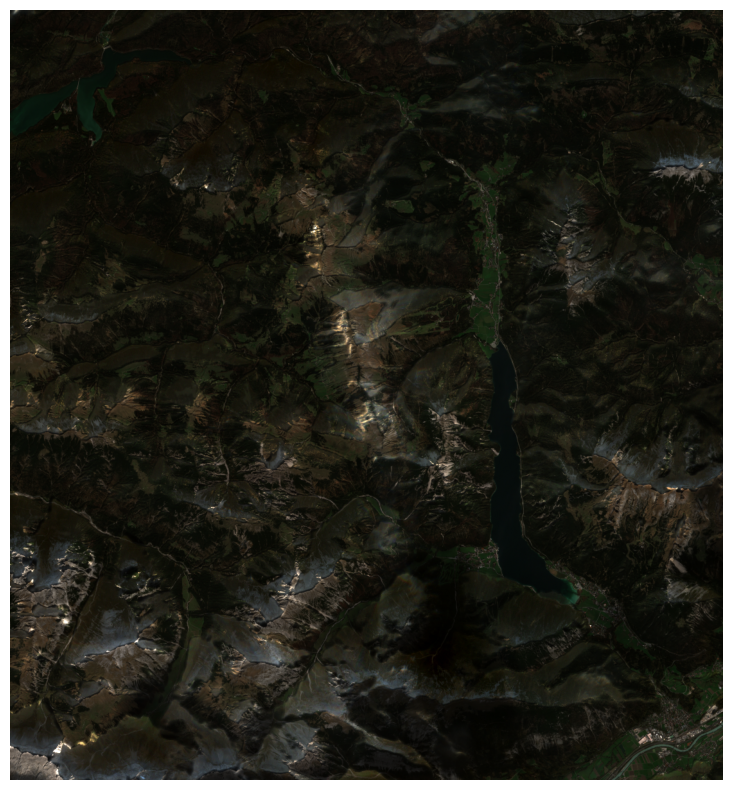

In [ ]:
image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image * (2/255))
ax.set_axis_off()
plt.show()

## Snow cover calculation

In [86]:
# Regular expression to match filenames like ndsi_yyyy-mm-dd.tiff
pattern = re.compile(r"ndsi_(\d{4}-\d{2}-\d{2})\.tiff")

# List to store datasets
datasets = []

# Loop through all files in the folder
for file in os.listdir(output_folder):
    match = pattern.match(file)
    if match:
        date_str = match.group(1)  # Extract the date part
        date = pd.to_datetime(date_str).date()  # Convert to date only (no time)
        file_path = os.path.join(output_folder, file)
        dataset = rxr.open_rasterio(file_path)

        # Check if time dimension exists
        if "time" in dataset.dims:
            print(f"{file}: Already has a time dimension.")
        else:
            # Expand the dataset with a new time dimension
            dataset = dataset.expand_dims(time=[pd.Timestamp(date)])
            print(f"Added time dimension to {file}")

        datasets.append(dataset)

Added time dimension to ndsi_2023-10-03.tiff
Added time dimension to ndsi_2023-10-10.tiff
Added time dimension to ndsi_2023-10-13.tiff
Added time dimension to ndsi_2023-10-23.tiff
Added time dimension to ndsi_2023-10-25.tiff
Added time dimension to ndsi_2023-10-28.tiff
Added time dimension to ndsi_2023-11-04.tiff
Added time dimension to ndsi_2023-11-27.tiff
Added time dimension to ndsi_2023-11-29.tiff
Added time dimension to ndsi_2023-12-07.tiff
Added time dimension to ndsi_2023-12-09.tiff
Added time dimension to ndsi_2023-12-17.tiff
Added time dimension to ndsi_2023-12-19.tiff
Added time dimension to ndsi_2023-12-27.tiff
Added time dimension to ndsi_2024-01-01.tiff
Added time dimension to ndsi_2024-01-03.tiff
Added time dimension to ndsi_2024-01-11.tiff
Added time dimension to ndsi_2024-01-13.tiff
Added time dimension to ndsi_2024-01-16.tiff
Added time dimension to ndsi_2024-01-28.tiff
Added time dimension to ndsi_2024-02-05.tiff
Added time dimension to ndsi_2024-02-07.tiff
Added time

In [87]:
# Merge all datasets along the time dimension
if datasets:
    combined_dataset = xr.concat(datasets, dim="time")
    print("Merged all datasets along the time dimension.")
else:
    print("No valid NDSI TIFF files found.")

# Print the dataset structure
print(combined_dataset.time.values)


Merged all datasets along the time dimension.
['2023-10-03T00:00:00.000000000' '2023-10-10T00:00:00.000000000'
 '2023-10-13T00:00:00.000000000' '2023-10-23T00:00:00.000000000'
 '2023-10-25T00:00:00.000000000' '2023-10-28T00:00:00.000000000'
 '2023-11-04T00:00:00.000000000' '2023-11-27T00:00:00.000000000'
 '2023-11-29T00:00:00.000000000' '2023-12-07T00:00:00.000000000'
 '2023-12-09T00:00:00.000000000' '2023-12-17T00:00:00.000000000'
 '2023-12-19T00:00:00.000000000' '2023-12-27T00:00:00.000000000'
 '2024-01-01T00:00:00.000000000' '2024-01-03T00:00:00.000000000'
 '2024-01-11T00:00:00.000000000' '2024-01-13T00:00:00.000000000'
 '2024-01-16T00:00:00.000000000' '2024-01-28T00:00:00.000000000'
 '2024-02-05T00:00:00.000000000' '2024-02-07T00:00:00.000000000'
 '2024-02-15T00:00:00.000000000' '2024-02-25T00:00:00.000000000'
 '2024-03-08T00:00:00.000000000' '2024-03-11T00:00:00.000000000'
 '2024-03-23T00:00:00.000000000' '2024-04-07T00:00:00.000000000'
 '2024-04-12T00:00:00.000000000' '2024-04-27

In [88]:
# Define snow threshold
snow_threshold = 0.42

# Create a binary snow cover map (1 = snow, 0 = no snow)
# Use np.where to handle NaN values explicitly
snow_cover_binary = xr.where(combined_dataset > snow_threshold, 1, 0)
# Preserve NaN values (keep them as NaN)
snow_cover_binary = snow_cover_binary.where(np.isfinite(combined_dataset), other=np.nan)

snow_cover_binary.coords['time'] = combined_dataset.coords['time']

In [89]:
# Save netCDF
snow_cover_binary.to_netcdf(
    output_folder + '/snow_cover_binary.nc'
)

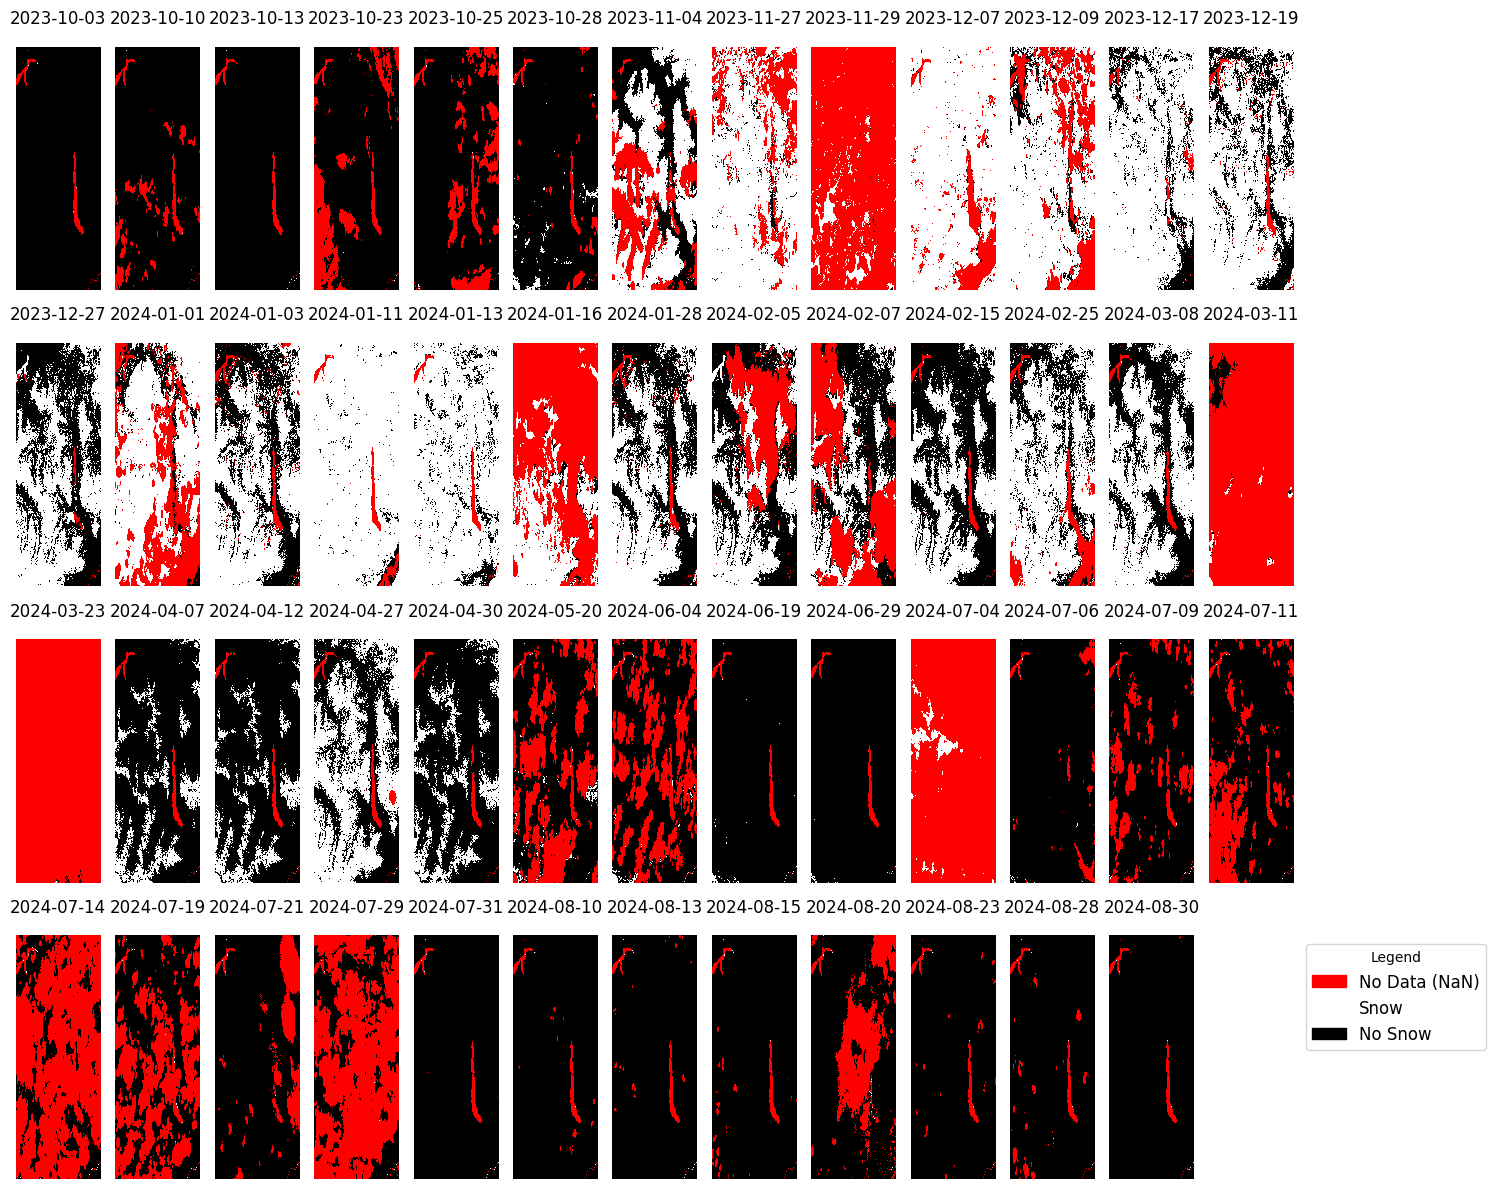

In [90]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Create a custom colormap: red for NaN, white for snow (1), and black for no snow (0)
cmap = ListedColormap(["red", "black", "white"])

# Define the number of rows
nrows = 4
# Calculate the number of columns based on the number of timesteps
ncols = int(np.ceil(len(snow_cover_binary.time) / nrows))

# Create a figure with subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 12))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Plot each timestep
for i, ax in enumerate(axes):
    if i < len(snow_cover_binary.time):
        # Access the i-th timestep and plot as a 2D array
        snow_data = snow_cover_binary.isel(time=i).squeeze()
        
        # Convert NaN values to -1 so that they can be mapped to red in the colormap
        snow_data_with_na = snow_data.copy()
        snow_data_with_na = snow_data_with_na.where(~np.isnan(snow_data_with_na), -1)  # Convert NaN to -1

        # Plot the snow cover data with the adjusted NaN values
        snow_data_with_na.plot.imshow(cmap=cmap, ax=ax, add_colorbar=False, interpolation='none')

        # Set the title with the corresponding date
        ax.set_title(f"{str(snow_cover_binary.time.values[i])[:10]}")
    
    ax.axis('off')  # Hide axis for better clarity

# Add custom legend outside the plot
legend_labels = ['No Data (NaN)', 'Snow', 'No Snow']
legend_colors = ['red', 'white', 'black']

# Create legend patches
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]

# Place the legend outside the plot
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1.05, 1), title='Legend', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [91]:
# Total number of pixels (including NaNs)
total_pixels = combined_dataset.sizes["x"] * combined_dataset.sizes["y"]

# Count valid (non-NaN) pixels per time step
valid_pixels = combined_dataset.notnull().sum(dim=["x", "y"])

# Count pixels where NDSI > 0.42
snow_pixels = (combined_dataset > snow_threshold).sum(dim=["x", "y"])

# Count NaN (no-data) pixels per time step
nodata_pixels = combined_dataset.isnull().sum(dim=["x", "y"])

# Calculate % snow cover (relative to total pixels)
snow_cover_percentage = (snow_pixels / (total_pixels - nodata_pixels)) * 100

# Calculate % no-data pixels (relative to total pixels)
nodata_percentage = (nodata_pixels / total_pixels) * 100

In [92]:
# Convert xarray DataArrays to 1D NumPy arrays for plotting
time_values_1d = combined_dataset.time.values  # Extract time values
snow_cover_percentage_1d = snow_cover_percentage.to_numpy().flatten()  # Convert to NumPy array
nodata_percentage_1d = nodata_percentage.to_numpy().flatten()  # Convert to NumPy array

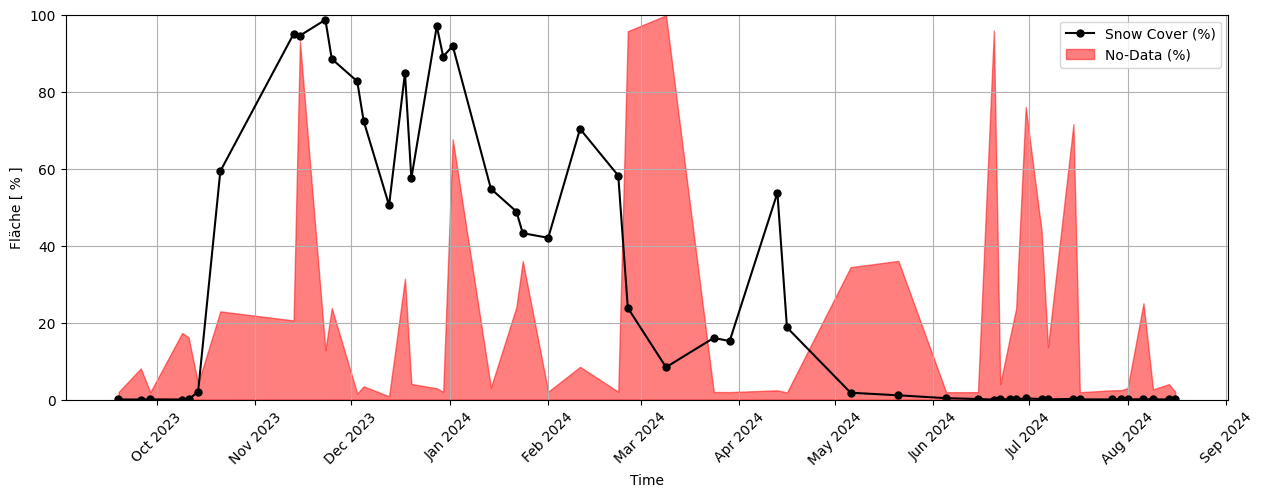

In [93]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create figure
plt.figure(figsize=(15, 5))

# Plot Snow Cover % as a blue line
plt.plot(time_values_1d, snow_cover_percentage_1d, marker="o", markersize=5, linestyle="-", 
         color="black", label="Snow Cover (%)")

# Fill No-Data % as a red shaded background
plt.fill_between(time_values_1d, nodata_percentage_1d, color="red", alpha=0.5, label="No-Data (%)")

# Formatting
plt.xlabel("Time")
plt.ylabel("Fläche [ % ]")
plt.ylim(0, 100)  # Ensures % range is 0-100%
plt.legend()
plt.grid()

# Adjust x-axis ticks (move to the middle of each month)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=15))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g., "Jan 2023"
plt.xticks(rotation=45)

plt.savefig(f"{output_folder}/snowcover.jpg", dpi=300, bbox_inches="tight")

# Show plot
plt.show()